In [1]:
import os
import sys
import torch
import torchvision
from torchvision import transforms
from tqdm import tqdm
import pandas as pd
from PIL import Image
import numpy as np
import random
import glob
import torch.nn.functional as F

sys.path.append(os.path.join('./Odysseus', 'Dataloader'))
sys.path.append(os.path.join('./Odysseus', 'Models'))

from MNIST_DL import SimpleDataset
from Load_Model import load_mnist_model
from minmax_normalize import minmax_normalize
from dataprep import prepare_mnist_data
from mask import MaskGenerator, train_decoupling_mask
from unet import UNet

In [2]:
# Paths
DATA_ROOT = os.path.join('./MNIST_Data')
TEST_IMG_DIR = os.path.join(DATA_ROOT, 'test')
CSV_PATH = os.path.join(TEST_IMG_DIR, 'test.csv')
MODELS_DIRS = [
    os.path.join('./MNIST_Models', 'Odysseus-MNIST', 'Models'),
]
MODELS_DIR_CLEAN = os.path.join('./Odysseus', 'Model Creation', 'checkpoint', 'MNIST_Models', 'Clean_models')
MODELS_DIR_TROJAN = os.path.join('./Odysseus', 'Model Creation', 'checkpoint', 'MNIST_Models', 'Trojan_models')

In [3]:
def evaluate_model(model_path, test_loader, device):
    """Evaluate a single model and return accuracy"""
    try:
        # Load model
        model, mapping = load_mnist_model(model_path, device)
        model.eval()
        
        # Get reported accuracy from checkpoint
        checkpoint = torch.load(model_path, map_location=device)
        reported_acc = checkpoint.get('test_clean_acc', None)
        
        # Evaluate
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch_idx, (data, target, _) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
        
        accuracy = 100 * correct / total
        return accuracy, reported_acc
        
    except Exception as e:
        print(f"Error evaluating {os.path.basename(model_path)}: {e}")
        return None, None

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare data
prepare_mnist_data()

# Load test dataset
test_dataset = SimpleDataset(DATA_ROOT, 'test.csv', data_transform=minmax_normalize)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

model_path = os.path.join(MODELS_DIR_TROJAN, 'Model_Google_1_alphatrigger_MNIST_Triangular90drightPattern_trojan.pth')

model, mapping = load_mnist_model(model_path, device)
model.eval()

# Split the model
Sa, Sb = model.convnet, model.fc  # or use your general splitting method

# Dummy forward pass to get feature size
with torch.no_grad():
    x_sample, _, _ = next(iter(test_loader))
    x_sample = x_sample.to(device)
    feat = Sa(x_sample)
    feat_dim = feat.view(x_sample.size(0), -1).shape[1]  # Flattened feature dim

# Init soft mask
init_mask = torch.zeros(1, feat_dim).to(device)
mask_generator = MaskGenerator(init_mask, Sb).to(device)

# Train the mask
train_decoupling_mask(mask_generator, Sa, Sb, test_loader, device, epochs=40, lr=1e-2)

100%|██████████████████████████████████| 10000/10000 [00:00<00:00, 13338.26it/s]
/home/tyler/Desktop/Odyssey/./Odysseus/Models/Load_Model.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

Saved 10000 test images to ./MNIST_Data/test
Saved CSV to ./MNIST_Data/test/test.csv
keys are : dict_keys(['net', 'Model Category', 'Architecture_Name', 'Learning_Rate', 'Loss Function', 'optimizer', 'Momentum', 'Weight decay', 'num_workers', 'Pytorch version', 'Trigger type', 'Trigger Size', 'Mapping', 'Trigger_location', 'Normalization Type', 'Mapping Type', 'Dataset', 'Batch Size', 'trigger_fraction', 'test_clean_acc', 'test_trigerred_acc', 'epoch'])
==> Building model..
The Accuracies on clean samples:   99.1125
The fooling rate:  97.55
Mapping is :  [7 6 9 4 8 1 3 2 0 5] <class 'numpy.ndarray'>


Epoch 1/40: 100%|███████████████████████████████| 79/79 [00:00<00:00, 97.17it/s]


Epoch  1/40: Avg Loss = -3.85e+04, Benign Accuracy = 0.6909


Epoch 2/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 112.18it/s]


Epoch  2/40: Avg Loss = -2.00e+06, Benign Accuracy = 0.9438


Epoch 3/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 115.48it/s]


Epoch  3/40: Avg Loss = -2.34e+07, Benign Accuracy = 0.9412


Epoch 4/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 115.97it/s]


Epoch  4/40: Avg Loss = -1.27e+08, Benign Accuracy = 0.9130


Epoch 5/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 113.80it/s]


Epoch  5/40: Avg Loss = -4.45e+08, Benign Accuracy = 0.8887


Epoch 6/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 115.84it/s]


Epoch  6/40: Avg Loss = -1.20e+09, Benign Accuracy = 0.8762


Epoch 7/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 116.35it/s]


Epoch  7/40: Avg Loss = -2.71e+09, Benign Accuracy = 0.8560


Epoch 8/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 112.71it/s]


Epoch  8/40: Avg Loss = -5.43e+09, Benign Accuracy = 0.8460


Epoch 9/40: 100%|██████████████████████████████| 79/79 [00:00<00:00, 113.09it/s]


Epoch  9/40: Avg Loss = -9.92e+09, Benign Accuracy = 0.8384


Epoch 10/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.08it/s]


Epoch 10/40: Avg Loss = -1.69e+10, Benign Accuracy = 0.6403


Epoch 11/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.71it/s]


Epoch 11/40: Avg Loss = -2.95e+10, Benign Accuracy = 0.2071


Epoch 12/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 105.60it/s]


Epoch 12/40: Avg Loss = -6.97e+10, Benign Accuracy = 0.1610


Epoch 13/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 109.59it/s]


Epoch 13/40: Avg Loss = -1.98e+11, Benign Accuracy = 0.1119


Epoch 14/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.85it/s]


Epoch 14/40: Avg Loss = -5.40e+11, Benign Accuracy = 0.1035


Epoch 15/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.44it/s]


Epoch 15/40: Avg Loss = -1.30e+12, Benign Accuracy = 0.1040


Epoch 16/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 116.25it/s]


Epoch 16/40: Avg Loss = -2.86e+12, Benign Accuracy = 0.1113


Epoch 17/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.93it/s]


Epoch 17/40: Avg Loss = -5.60e+12, Benign Accuracy = 0.1491


Epoch 18/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 115.19it/s]


Epoch 18/40: Avg Loss = -9.76e+12, Benign Accuracy = 0.1169


Epoch 19/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.89it/s]


Epoch 19/40: Avg Loss = -1.57e+13, Benign Accuracy = 0.1213


Epoch 20/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.68it/s]


Epoch 20/40: Avg Loss = -2.40e+13, Benign Accuracy = 0.1282


Epoch 21/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.01it/s]


Epoch 21/40: Avg Loss = -3.49e+13, Benign Accuracy = 0.1365


Epoch 22/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 108.25it/s]


Epoch 22/40: Avg Loss = -4.90e+13, Benign Accuracy = 0.1371


Epoch 23/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.49it/s]


Epoch 23/40: Avg Loss = -6.70e+13, Benign Accuracy = 0.1365


Epoch 24/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.70it/s]


Epoch 24/40: Avg Loss = -8.89e+13, Benign Accuracy = 0.1375


Epoch 25/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 115.45it/s]


Epoch 25/40: Avg Loss = -1.15e+14, Benign Accuracy = 0.1289


Epoch 26/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.93it/s]


Epoch 26/40: Avg Loss = -1.47e+14, Benign Accuracy = 0.1270


Epoch 27/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.94it/s]


Epoch 27/40: Avg Loss = -1.85e+14, Benign Accuracy = 0.1187


Epoch 28/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.54it/s]


Epoch 28/40: Avg Loss = -2.28e+14, Benign Accuracy = 0.1128


Epoch 29/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.92it/s]


Epoch 29/40: Avg Loss = -2.79e+14, Benign Accuracy = 0.1108


Epoch 30/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.03it/s]


Epoch 30/40: Avg Loss = -3.37e+14, Benign Accuracy = 0.1116


Epoch 31/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.70it/s]


Epoch 31/40: Avg Loss = -4.03e+14, Benign Accuracy = 0.1116


Epoch 32/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.59it/s]


Epoch 32/40: Avg Loss = -4.77e+14, Benign Accuracy = 0.1121


Epoch 33/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.11it/s]


Epoch 33/40: Avg Loss = -5.61e+14, Benign Accuracy = 0.1112


Epoch 34/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.50it/s]


Epoch 34/40: Avg Loss = -6.54e+14, Benign Accuracy = 0.1107


Epoch 35/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.12it/s]


Epoch 35/40: Avg Loss = -7.57e+14, Benign Accuracy = 0.1104


Epoch 36/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.77it/s]


Epoch 36/40: Avg Loss = -8.72e+14, Benign Accuracy = 0.1082


Epoch 37/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.31it/s]


Epoch 37/40: Avg Loss = -9.98e+14, Benign Accuracy = 0.1082


Epoch 38/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 112.30it/s]


Epoch 38/40: Avg Loss = -1.14e+15, Benign Accuracy = 0.1084


Epoch 39/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 113.54it/s]


Epoch 39/40: Avg Loss = -1.29e+15, Benign Accuracy = 0.1120


Epoch 40/40: 100%|█████████████████████████████| 79/79 [00:00<00:00, 114.69it/s]

Epoch 40/40: Avg Loss = -1.45e+15, Benign Accuracy = 0.1118
✅ Mask training complete.


In [5]:
mask_generator.get_raw_mask()

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.9846e-05,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9998e-01, 9.9994e-01, 0.0000e+00,
         9.9997e-01, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9996e-01, 9.9998e-01, 0.0000e+00, 0.0000e+00, 9.9974e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9997e-01, 2.6822e-07,
         0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 9.9995e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9999e-01, 0.0000e+00, 2.9802e-08,
         0.0000e+00, 1.1712e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         9.9970e-01, 9.9981e-01, 0.0000e+00, 9.9999e-01, 1.6689e-06, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9990e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0700e-02, 0.0000e+00, 0.0000e+00, 1.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 9.9989e-01, 9.9977e-01, 0.0000e+00,
         0.0000e+00, 0.0000e

In [6]:
def trigger_inversion_loss(x, Gx, Sa, m, tau=0.01):
    feat_x = Sa(x).view(x.size(0), -1)
    feat_Gx = Sa(Gx).view(x.size(0), -1)

    diff = feat_x - feat_Gx
    benign_diff = (diff * m).norm(p=2, dim=1)
    backdoor_diff = (diff * (1 - m)).norm(p=2, dim=1)
    main_loss = (benign_diff - backdoor_diff).mean()

    # Differentiable hard constraint: hinge
    mse_loss = F.mse_loss(Gx, x)
    constraint_loss = F.relu(mse_loss - tau)

    return main_loss, constraint_loss

In [7]:
def train_unet_trigger_generator(G, Sa, mask, dataloader, device, epochs=40, lr=1e-3, tau=0.01, constraint_weight=5000.0):
    G.train()
    Sa.eval()
    mask = mask.detach()

    optimizer = torch.optim.Adam(G.parameters(), lr=lr)

    for epoch in range(epochs):
        total_main, total_constraint = 0, 0

        for x, y, *_ in dataloader:
            x = x.to(device)

            # Forward pass
            Gx = torch.sigmoid(G(x))  # [0,1] range

            # Losses
            loss_main, loss_constraint = trigger_inversion_loss(x, Gx, Sa, mask, tau)
            loss = loss_main + constraint_weight * loss_constraint

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_main += loss_main.item()
            total_constraint += loss_constraint.item()

        print(f"Epoch {epoch+1:02d}: Inversion Loss = {total_main:.4f}, Constraint = {total_constraint:.4f}")

In [8]:
def visualize_inverse_trigger(G, x):
    G.eval()
    with torch.no_grad():
        Gx = torch.sigmoid(G(x))
        delta = Gx - x

    import matplotlib.pyplot as plt
    x_np = x.cpu().squeeze().numpy()
    Gx_np = Gx.cpu().squeeze().numpy()
    delta_np = delta.cpu().squeeze().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(9, 3))
    axs[0].imshow(x_np, cmap='gray')
    axs[0].set_title("Original")
    axs[1].imshow(Gx_np, cmap='gray')
    axs[1].set_title("Poisoned")
    axs[2].imshow(delta_np, cmap='hot')
    axs[2].set_title("Trigger (Δ)")
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [9]:
# Assume you already have: Sa, trained mask_generator, test_loader
mask = mask_generator.get_raw_mask().detach()

# Initialize U-Net trigger generator
G = UNet(
    n_channels=1,
    base_filter_num=16,
    num_blocks=2,
    num_classes=1,
    mode='2D'
)
G.to(device)

x = torch.randn(1, 1, 28, 28).to(device)
y = G(x)
assert y.shape[-2:] == (28, 28), f"UNet output is {y.shape[-2:]} — should be (28, 28)"

Epoch 01: Inversion Loss = -467.4009, Constraint = 7.1178
Epoch 02: Inversion Loss = -393.8871, Constraint = 2.2426
Epoch 03: Inversion Loss = -305.5627, Constraint = 0.5768
Epoch 04: Inversion Loss = -268.2843, Constraint = 0.0535
Epoch 05: Inversion Loss = -284.3356, Constraint = 0.0041
Epoch 06: Inversion Loss = -320.6798, Constraint = 0.0026
Epoch 07: Inversion Loss = -337.7502, Constraint = 0.0038
Epoch 08: Inversion Loss = -358.5505, Constraint = 0.0034
Epoch 09: Inversion Loss = -360.8583, Constraint = 0.0021
Epoch 10: Inversion Loss = -397.2603, Constraint = 0.0024
Epoch 11: Inversion Loss = -418.4636, Constraint = 0.0035
Epoch 12: Inversion Loss = -410.6390, Constraint = 0.0027
Epoch 13: Inversion Loss = -439.5594, Constraint = 0.0017
Epoch 14: Inversion Loss = -416.7117, Constraint = 0.0011
Epoch 15: Inversion Loss = -441.3557, Constraint = 0.0021
Epoch 16: Inversion Loss = -464.1510, Constraint = 0.0021
Epoch 17: Inversion Loss = -495.5241, Constraint = 0.0028
Epoch 18: Inve

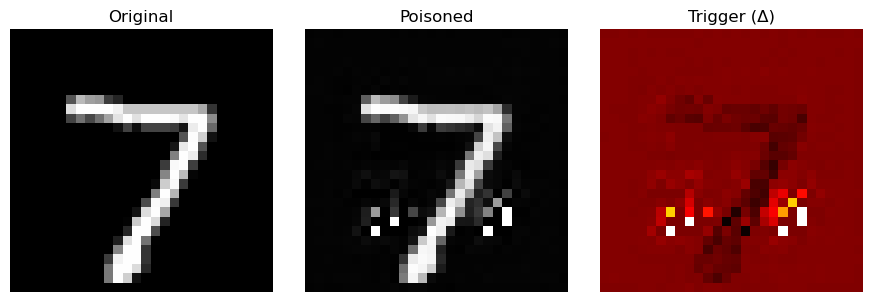

In [10]:

# Train it
train_unet_trigger_generator(G, Sa, mask, test_loader, device)

# Visualize inverse trigger
x_sample, _, _ = next(iter(test_loader))
x_sample = x_sample[:1].to(device)  # take one sample
visualize_inverse_trigger(G, x_sample)